# Using a Neural Network to predict clean signals from noisy data

In [1]:
from utils import noise_generator
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import matplotlib.pyplot as plt

In [2]:
# Parameters
num_signals = 5000
signal_length = 128
noise_bounds = [-2 ,2]
rng = np.random.default_rng()

freq_range = [1,15]
amplitude_range =[0.1, 5]


# Generate clean signals
clean_signals = []
for _ in range(num_signals):
    x = np.linspace(0, 2 * np.pi, signal_length)
    freq = rng.uniform(freq_range[0], freq_range[1])  # Random frequency
    amplitude = rng.uniform(amplitude_range[0], amplitude_range[1])  # Random amplitude
    phase = rng.uniform(0, 2 * np.pi)  # Random phase
    clean_signal = amplitude * np.sin(freq * x + phase)
    clean_signals.append(clean_signal)
clean_signals = np.array(clean_signals)

# Generate noisy signals
noisy_signals = np.array([noise_generator(signal, noise_bounds) for signal in clean_signals])

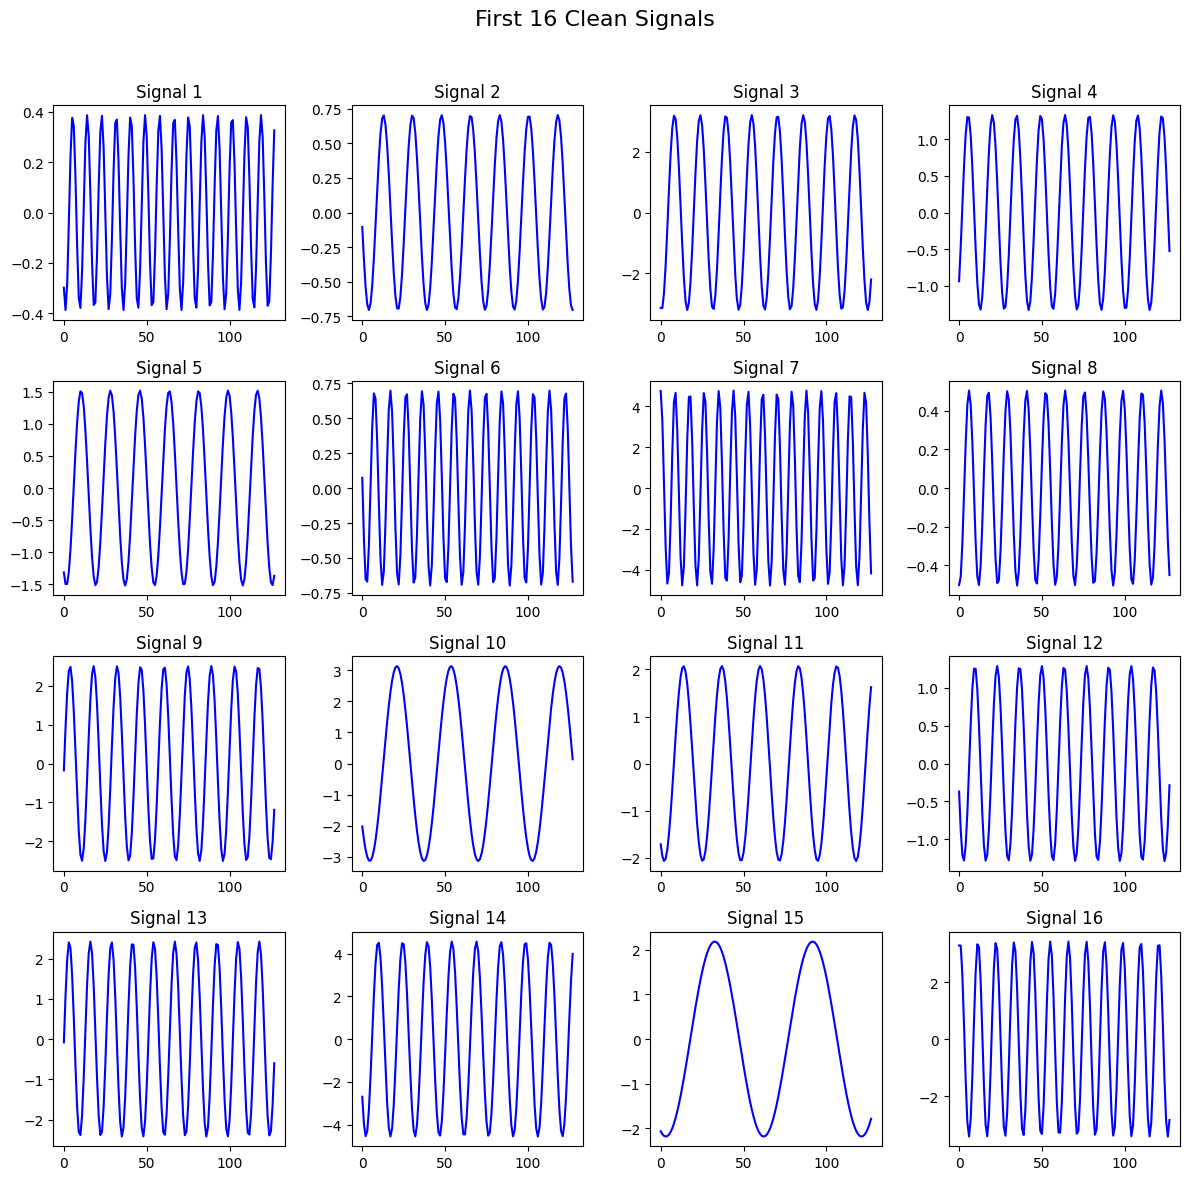

In [3]:
# Plot the first 16 clean signals in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # Create a 4x4 grid of subplots
fig.suptitle("First 16 Clean Signals", fontsize=16)  # Add a title for the grid

for i, ax in enumerate(axes.flatten()):  # Flatten the 2D array of axes for easy iteration
    ax.plot(clean_signals[i], color='blue')  # Plot the i-th clean signal
    ax.set_title(f"Signal {i+1}")  # Set a title for each subplot
    #ax.set_xticks([])  # Remove x-axis ticks for clarity
    #ax.set_yticks([])  # Remove y-axis ticks for clarity

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust spacing to prevent overlap
plt.show()

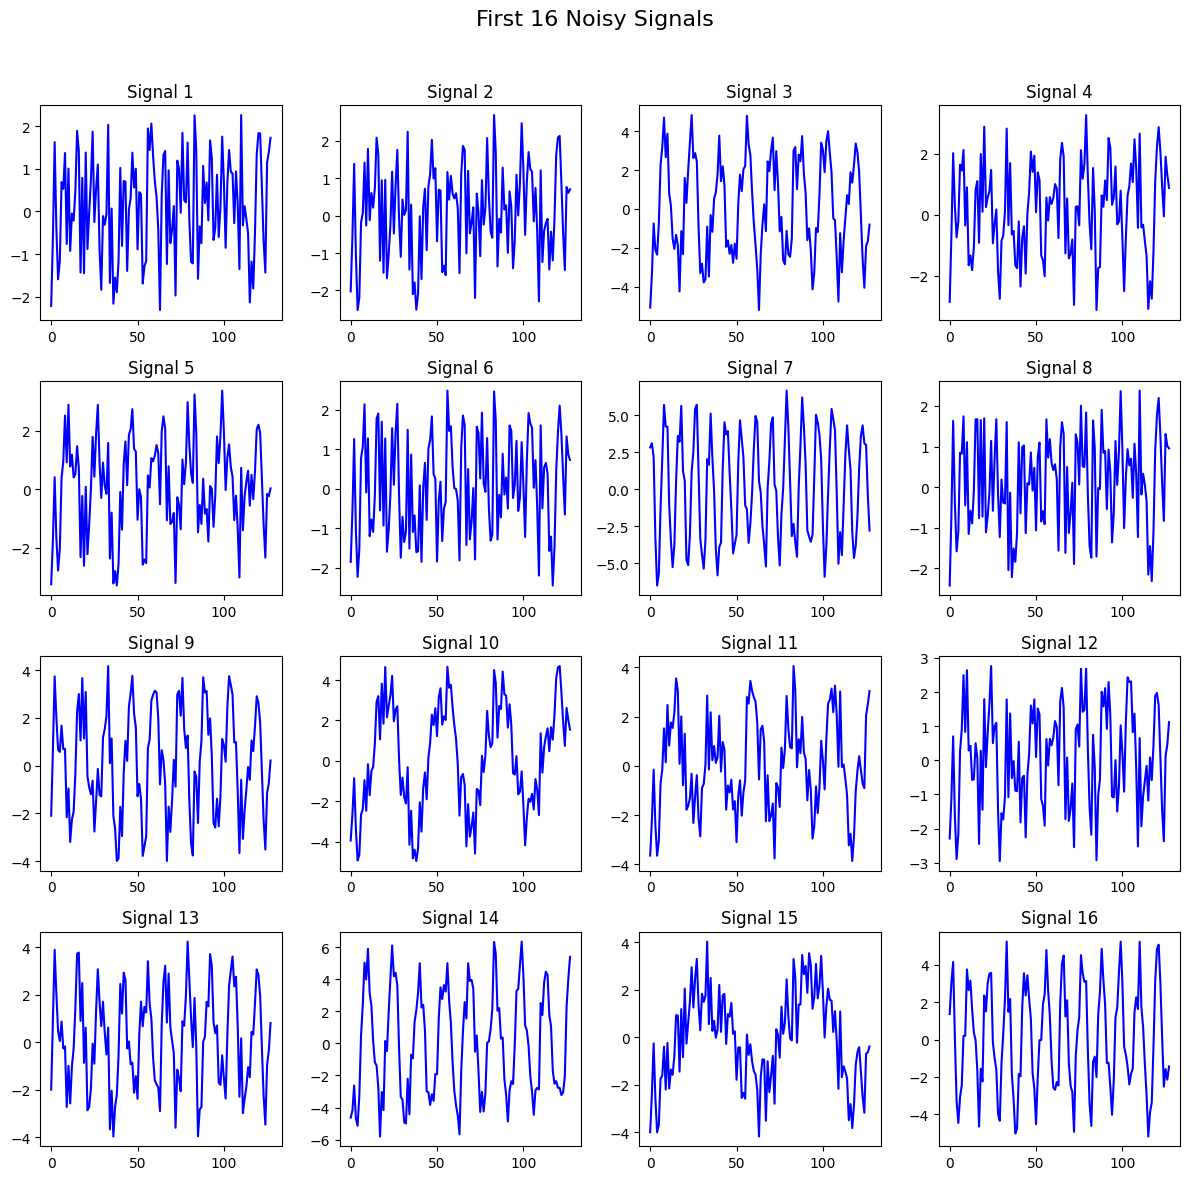

In [4]:
# Plot the first 16 clean signals in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # Create a 4x4 grid of subplots
fig.suptitle("First 16 Noisy Signals", fontsize=16)  # Add a title for the grid

for i, ax in enumerate(axes.flatten()):  # Flatten the 2D array of axes for easy iteration
    ax.plot(noisy_signals[i], color='blue')  # Plot the i-th clean signal
    ax.set_title(f"Signal {i+1}")  # Set a title for each subplot

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust spacing to prevent overlap
plt.show()

In [5]:
# Reshape for neural network input
X = noisy_signals.reshape(-1, signal_length, 1)  # Noisy signals as inputs
y = clean_signals.reshape(-1, signal_length, 1)  # Clean signals as targets

# Split into train, validation, and test sets
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# Define the learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,  # Start with 0.001
    decay_steps=10000,           # Decay every 10,000 steps
    decay_rate=0.9               # Reduce by 10% each time
)

# Build the model
model = models.Sequential([
    layers.Input(shape=(128, 1)),  # Input layer with shape (128, 1)
    
    # First Conv block
    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling1D(pool_size=2),  # Downsample by 2
    
    # Second Conv block
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.Conv1D(256, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling1D(pool_size=2),  # Downsample by 2
    
    # Bottleneck
    layers.Conv1D(256, kernel_size=3, activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    
    # Upsampling block
    layers.Conv1DTranspose(256, kernel_size=3, activation='relu', padding='same',
                           kernel_regularizer=regularizers.l2(0.001)),
    layers.UpSampling1D(size=2),  # Upsample by 2
    
    layers.Conv1DTranspose(128, kernel_size=3, activation='relu', padding='same',
                           kernel_regularizer=regularizers.l2(0.001)),
    layers.UpSampling1D(size=2),  # Upsample by 2
    
    # Final reconstruction layer
    layers.Conv1D(1, kernel_size=3, activation='linear', padding='same',
                  kernel_regularizer=regularizers.l2(0.001))
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae'])

# Print the model summary
model.summary()

2024-11-18 13:37:54.613952: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-18 13:37:54.613976: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-11-18 13:37:54.613980: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-11-18 13:37:54.613992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-18 13:37:54.614001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 64, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 32, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 32, 256)        │       196,864 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 64, 128)        │        98,432 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 128, 1)         │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 665,345 (2.54 MB)

 Trainable params: 665,345 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, y_val)
)

Epoch 1/50


2024-11-18 13:37:55.435923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 3.5144 - mae: 1.1933 - val_loss: 1.4076 - val_mae: 0.5624
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.2569 - mae: 0.5054 - val_loss: 1.0656 - val_mae: 0.4170
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.0343 - mae: 0.4068 - val_loss: 0.9581 - val_mae: 0.3775
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.9244 - mae: 0.3606 - val_loss: 0.8748 - val_mae: 0.3448
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.8434 - mae: 0.3234 - val_loss: 0.8085 - val_mae: 0.3117
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.7870 - mae: 0.2970 - val_loss: 0.7651 - val_mae: 0.2967
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.7470 - mae: 0.2841 - val_loss: 0.7181 - val_mae: 0.2727
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.7108 - mae: 0.2727 - val_loss: 0.6872 - val_mae: 0.2664
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.6812 - mae: 0.

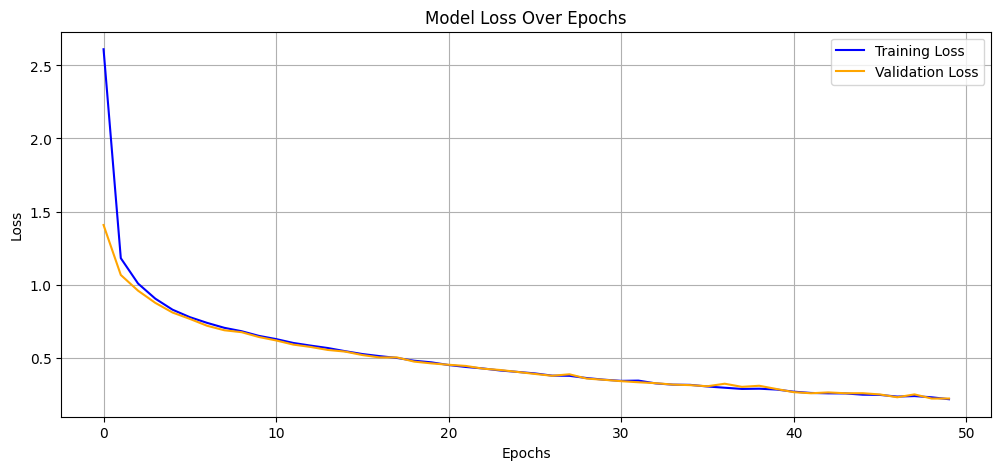

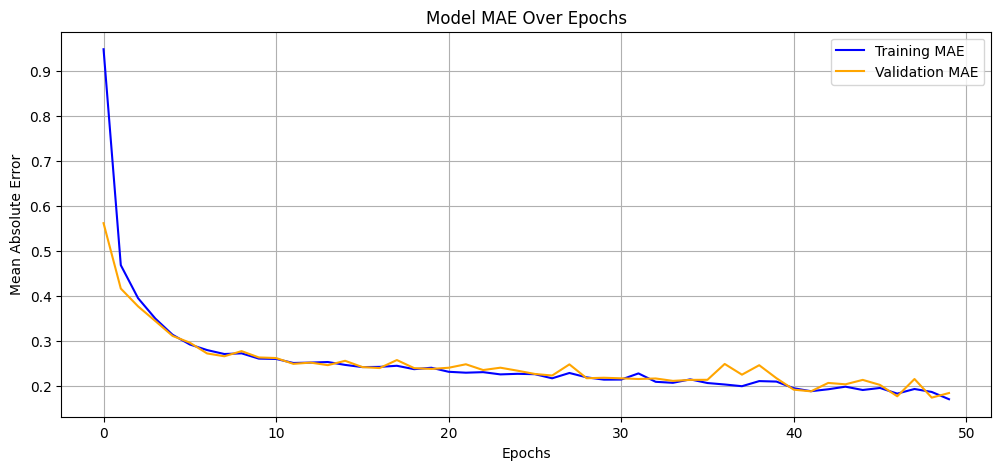

In [8]:
# Access the training history
history_dict = history.history  # Extract the training history
# Extract training and validation loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Extract training and validation MAE
train_mae = history_dict.get('mae', None)  # Get MAE if it was tracked
val_mae = history_dict.get('val_mae', None)


# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE (if available)
if train_mae and val_mae:
    plt.figure(figsize=(12, 5))
    plt.plot(train_mae, label='Training MAE', color='blue')
    plt.plot(val_mae, label='Validation MAE', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('Model MAE Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

## Evaluate model on old and new data

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2207 - mae: 0.1850
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


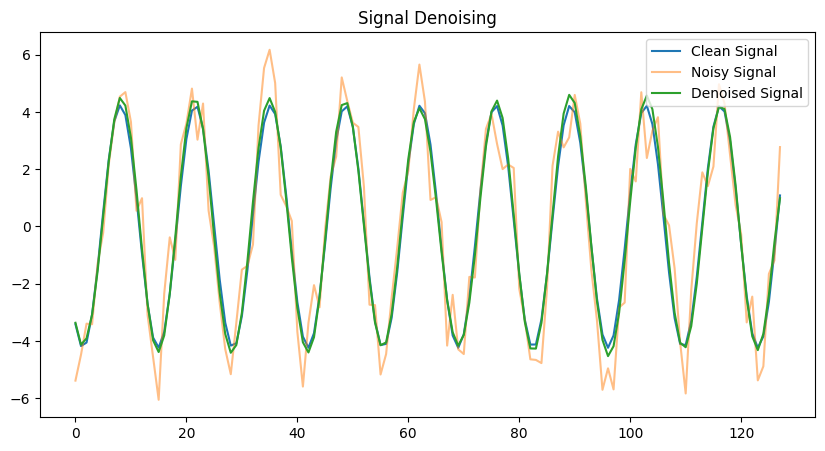

In [9]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)

# Visualize a sample
sample_idx = 0
predicted_signal = model.predict(X_test[sample_idx:sample_idx+1])[0].squeeze()
plt.figure(figsize=(10, 5))
plt.plot(y_test[sample_idx].squeeze(), label='Clean Signal')
plt.plot(X_test[sample_idx].squeeze(), label='Noisy Signal', alpha=0.5)
plt.plot(predicted_signal, label='Denoised Signal')
plt.legend()
plt.title("Signal Denoising")
plt.show()

In [10]:
# Generate 16 new clean signals
num_new_signals = 16
new_clean_signals = []
for _ in range(num_new_signals):
    x = np.linspace(0, 2 * np.pi, signal_length)
    freq = rng.uniform(freq_range[0], freq_range[1])  # Random frequency
    amplitude = rng.uniform(amplitude_range[0], amplitude_range[1])  # Random amplitude
    phase = rng.uniform(0, 2 * np.pi)  # Random phase
    clean_signal = amplitude * np.sin(freq * x + phase)
    new_clean_signals.append(clean_signal)
new_clean_signals = np.array(new_clean_signals)

# Generate noisy signals for the new clean signals
new_noisy_signals = np.array([noise_generator(signal, noise_bounds) for signal in new_clean_signals])

In [11]:
# Reshape the signals for model input
X_new_noisy = new_noisy_signals.reshape(-1, signal_length, 1)
y_new_clean = new_clean_signals.reshape(-1, signal_length, 1)

# Predict the denoised signals
denoised_signals = model.predict(X_new_noisy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


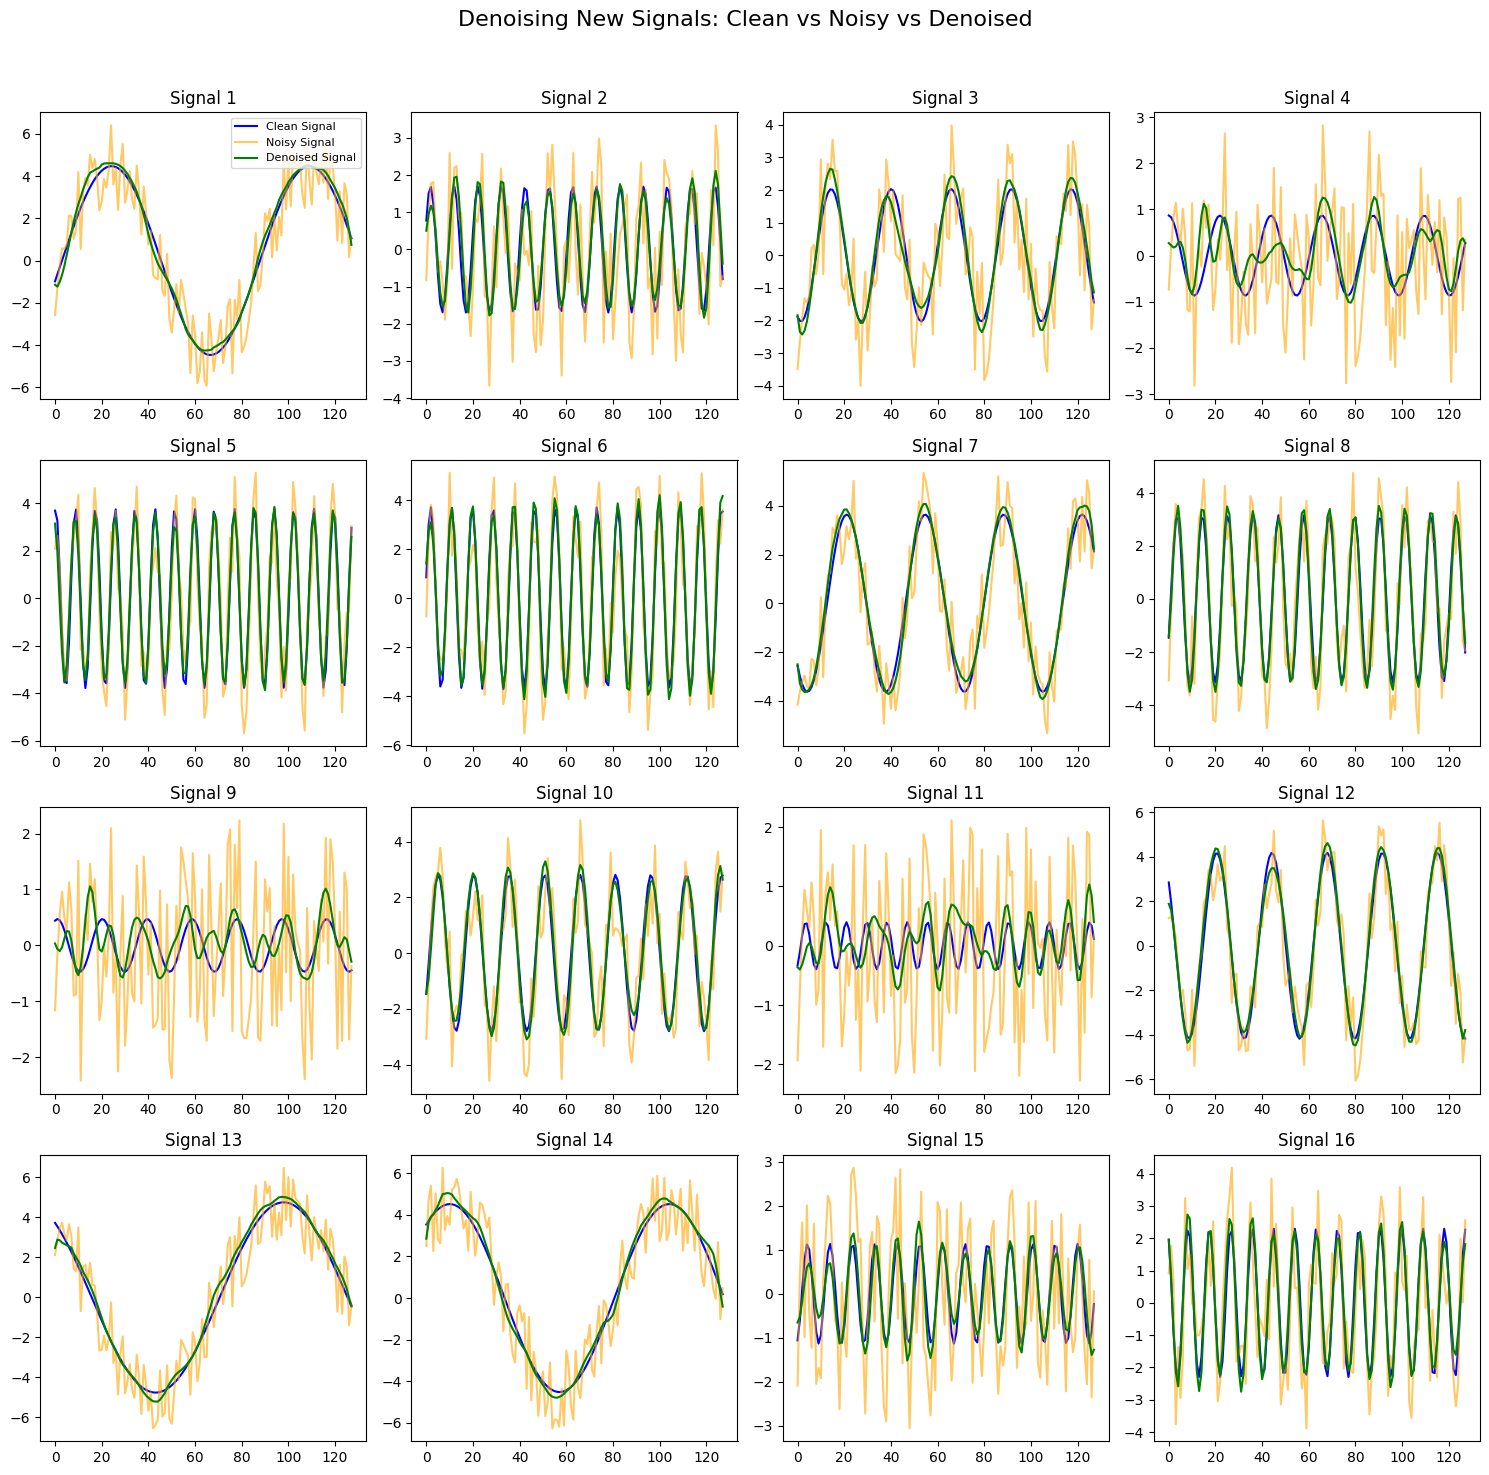

In [12]:
# Plot the results in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
fig.suptitle("Denoising New Signals: Clean vs Noisy vs Denoised", fontsize=16)

for i, ax in enumerate(axes.flatten()):
    ax.plot(new_clean_signals[i], label='Clean Signal', color='blue')
    ax.plot(new_noisy_signals[i], label='Noisy Signal', color='orange', alpha=0.6)
    ax.plot(denoised_signals[i].squeeze(), label='Denoised Signal', color='green')
    ax.set_title(f"Signal {i+1}")
    
    if i == 0:  # Add legend to the first subplot only for clarity
        ax.legend(loc='upper right', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [13]:
model.evaluate(X_new_noisy, y_new_clean)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2684 - mae: 0.2602


[0.26844990253448486, 0.26017600297927856]

In [14]:
# save model to supload to netron for vizualization
model.save('model.h5')

In [15]:
# display with vizualkeras package
import visualkeras
visualkeras.layered_view(model, legend=True).show()

/opt/anaconda3/envs/mphys/lib/python3.9/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


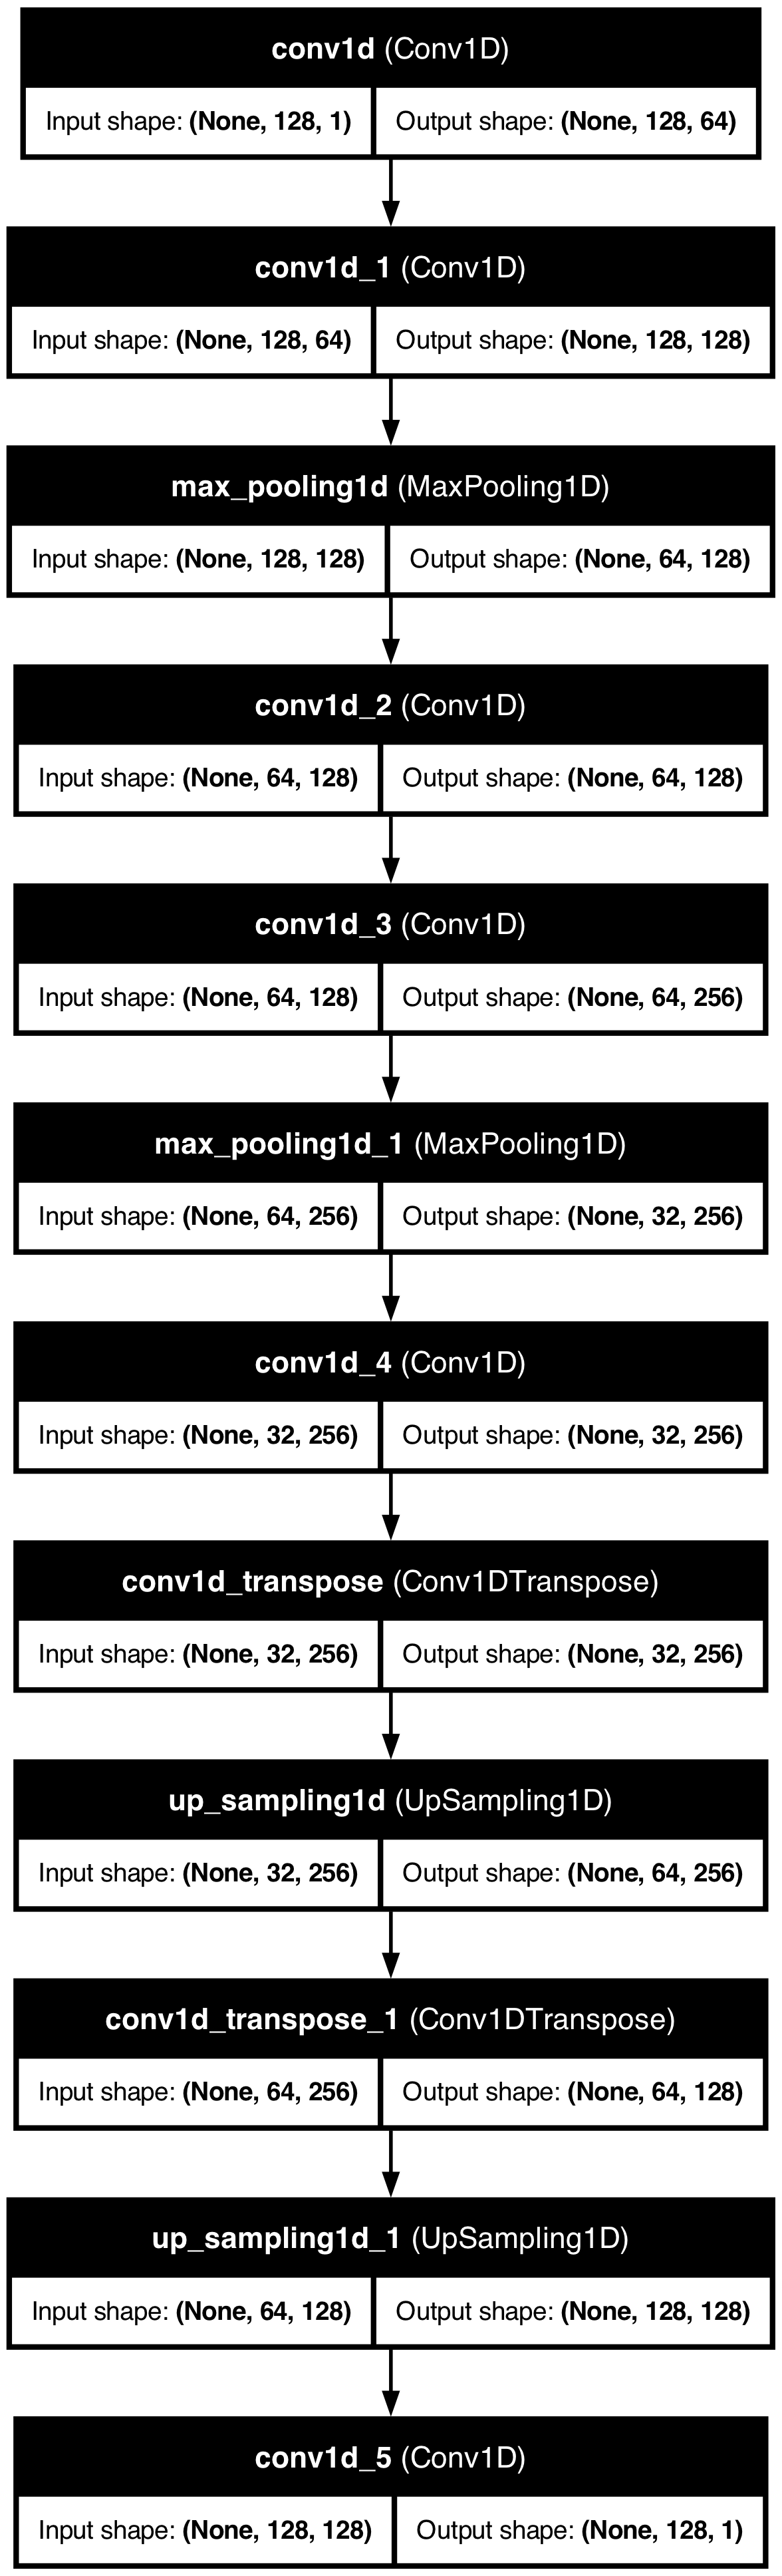

In [16]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)